In [ ]:
pip install shap lime interpret-core

  Using cached lime-0.2.0.1.tar.gz (275 kB)
  Preparing metadata (setup.py) ... done
  Using cached interpret_core-0.6.16-py3-none-any.whl.metadata (3.0 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 82.8 MB/s eta 0:00:00
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=21ba7acb79555ef731208f36448a25d6c612f1f19d8839ba1a0001625e0c7cb1
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, LinearRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import interpret.glassbox
import xgboost
import shap
import lime
import lime.lime_tabular
import sklearn
import warnings
warnings.filterwarnings('ignore')

In [ ]:
data = pd.read_csv("/content/telecomchurn.csv")
data.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [ ]:
#del data['Unnamed: 0'] ## delete Unnamed: 0
le = LabelEncoder() ## perform label encoding
#data['area_code_tr'] = le.fit_transform(data['area_code'])
del data['area code'] ## delete area_code
data['churn_dum'] = pd.get_dummies(data.
churn,prefix='churn',drop_first=True)
del data['international plan'] ## delete international_plan
del data['voice mail plan'] ## delete voice_mail_plan
del data['churn'] ## delete churn
data.info()
data.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   area code               3333 non-null   int64  
 3   phone number            3333 non-null   object 
 4   number vmail messages   3333 non-null   int64  
 5   total day minutes       3333 non-null   float64
 6   total day calls         3333 non-null   int64  
 7   total day charge        3333 non-null   float64
 8   total eve minutes       3333 non-null   float64
 9   total eve calls         3333 non-null   int64  
 10  total eve charge        3333 non-null   float64
 11  total night minutes     3333 non-null   float64
 12  total night calls       3333 non-null   int64  
 13  total night charge      3333 non-null   float64
 14  total intl minutes      3333 non-null   

Index(['state', 'account length', 'area code', 'phone number',
       'number vmail messages', 'total day minutes', 'total day calls',
       'total day charge', 'total eve minutes', 'total eve calls',
       'total eve charge', 'total night minutes', 'total night calls',
       'total night charge', 'total intl minutes', 'total intl calls',
       'total intl charge', 'customer service calls', 'churn_dum'],
      dtype='object')

In [ ]:
X = data.drop('churn_dum',axis=1)
Y = data['churn_dum']
# One-hot encode the 'state' column
X = pd.get_dummies(X, columns=['state'], drop_first=True)
# Drop the 'phone number' column as it is not a useful feature for the model
X = X.drop('phone number', axis=1)
xtrain,xtest,ytrain,ytest=train_test_split(X,Y,test_size=0.20,stratify=Y)
l_model = LogisticRegression()
l_model.fit(xtrain,ytrain)
print("training accuracy:", l_model.score(xtrain,ytrain)) #training accuracy
print("test accuracy:",l_model.score(xtest,ytest)) # test accuracy

training accuracy: 0.8503375843960991
test accuracy: 0.8620689655172413


In [ ]:
# Provide Probability as Output
def m_churn_proba(x):
   return l_model.predict_proba(x)[:,1]
# Provide Log Odds as Output
def model_churn_log_odds(x):
   p = l_model.predict_log_proba(x)
   return p[:,1] - p[:,0]

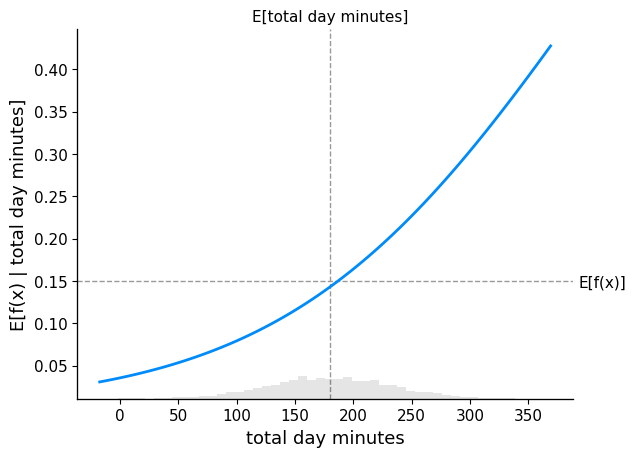

In [ ]:
# PDP
sample_ind = 25
fig,ax = shap.partial_dependence_plot("total day minutes", m_churn_proba, X, model_expected_value=True,feature_expected_value=True, show=False, ice=False)

In [ ]:
# SHAP values computation
# Drop rows with NaN values from X
X_cleaned = X.dropna()
background_c = shap.maskers.Independent(X_cleaned, max_samples=1000) ## Concealed features may be hidden by using this function.
explainer = shap.Explainer(l_model, background_c,
feature_names=list(X_cleaned.columns))
shap_values_c = explainer(X_cleaned)

# Convert SHAP values to numeric, coercing errors
shap_values_numeric = pd.DataFrame(shap_values_c.values).apply(pd.to_numeric, errors='coerce').values

# Reconstruct the shap_values_c Explanation object with numeric values
shap_values_c = shap.Explanation(
    values=shap_values_numeric,
    base_values=shap_values_c.base_values,
    data=X_cleaned.values,
    feature_names=list(X_cleaned.columns)
)

shap_values = pd.DataFrame(shap_values_c.values)
shap_values.columns = list(X_cleaned.columns)
shap_values

,account length,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,...,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY
0,-0.044791,-0.516594,0.757738,-0.085429,0.022228,-0.004405,0.010815,-0.000007,-0.063042,0.116400,...,0.000089,0.000087,-0.000412,-0.000029,0.000234,0.000222,-0.00016,0.000315,0.000198,-0.000003
1,-0.008711,-0.546923,-0.154160,-0.202740,-0.004525,-0.008064,-0.032793,-0.000013,-0.077234,-0.029541,...,0.000089,0.000087,-0.000412,-0.000029,0.000234,0.000222,-0.00016,0.000315,0.000198,-0.000003
2,-0.060254,0.241631,0.566548,-0.121525,0.016619,-0.151170,-0.109105,-0.000250,0.057073,-0.041702,...,0.000089,0.000087,-0.000412,-0.000029,0.000234,0.000222,-0.00016,0.000315,0.000198,-0.000003
3,0.030806,0.241631,1.059942,0.266504,0.031090,-0.265385,0.130734,-0.000439,0.006891,0.140723,...,0.000089,0.000087,-0.000412,-0.000029,0.000234,0.000222,-0.00016,0.000315,0.000198,-0.000003
4,0.046269,0.241631,-0.109226,-0.112501,-0.003203,-0.098974,-0.239927,-0.000163,0.021521,-0.248451,...,0.000089,0.000087,-0.000412,-0.000029,0.000234,0.000222,-0.00016,0.000315,0.000198,-0.000003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,-0.154750,-0.850212,-0.201737,0.212360,-0.005924,0.030457,-0.283534,0.000050,-0.113371,0.213693,...,0.000089,0.000087,-0.000412,-0.000029,0.000234,0.000222,-0.00016,0.000315,0.000198,-0.000003
3329,0.058295,0.241631,0.458177,0.392838,0.013442,-0.089151,0.490493,-0.000147,0.015084,-0.272775,...,0.000089,0.000087,-0.000412,-0.000029,0.000234,0.000222,-0.00016,0.000315,-0.005007,-0.000003
3330,0.127020,0.241631,0.015004,-0.076406,0.000445,0.171637,0.457788,0.000284,0.014206,0.116400,...,0.000089,0.000087,-0.000412,-0.000029,0.000234,0.000222,-0.00016,0.000315,0.000198,-0.000003
3331,-0.141005,0.241631,0.305754,-0.040310,0.008973,-0.077210,0.174341,-0.000127,0.091308,-0.443038,...,0.000089,0.000087,-0.000412,-0.000029,0.000234,0.000222,-0.00016,0.000315,0.000198,-0.000003


In [ ]:
print("Shape of shap_values_c.values:", shap_values_c.values.shape)
print("Data type of shap_values_c.values:", shap_values_c.values.dtype)
print("Checking for NaN values in shap_values_c.values:", np.isnan(shap_values_c.values).sum())
print("Checking for infinite values in shap_values_c.values:", np.isinf(shap_values_c.values).sum())
print("Min value in shap_values_c.values:", np.min(shap_values_c.values))
print("Max value in shap_values_c.values:", np.max(shap_values_c.values))

# Check if there are any non-scalar elements within the array
is_scalar = np.vectorize(np.isscalar)
print("Checking if all elements in shap_values_c.values are scalar:", is_scalar(shap_values_c.values).all())

Shape of shap_values_c.values: (3333, 65)
Data type of shap_values_c.values: float64
Checking for NaN values in shap_values_c.values: 0
Checking for infinite values in shap_values_c.values: 0
Min value in shap_values_c.values: -1.9563150277710828
Max value in shap_values_c.values: 2.4965842402428287
Checking if all elements in shap_values_c.values are scalar: True


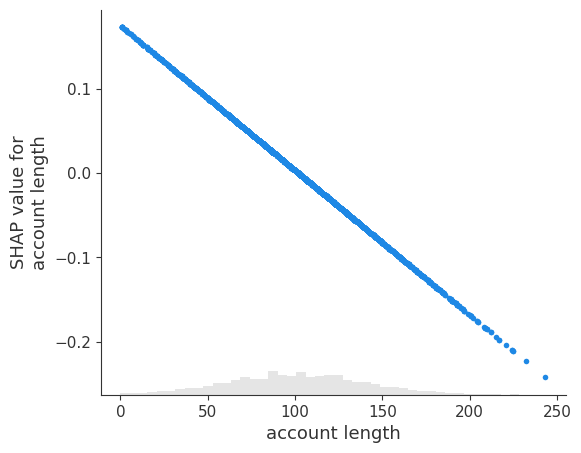

In [ ]:
shap.plots.scatter(shap_values_c[:,'account length'])

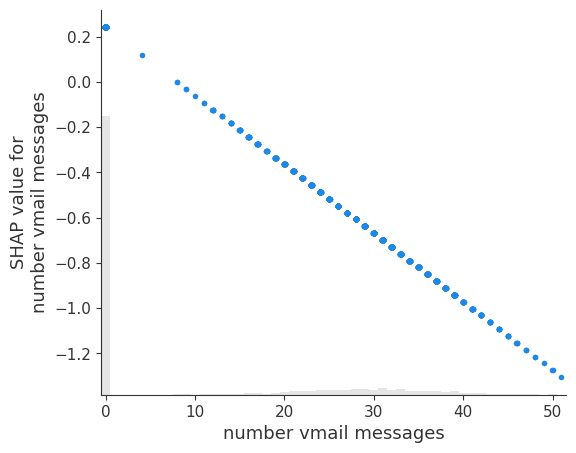

In [ ]:
shap.plots.scatter(shap_values_c[:,'number vmail messages'])

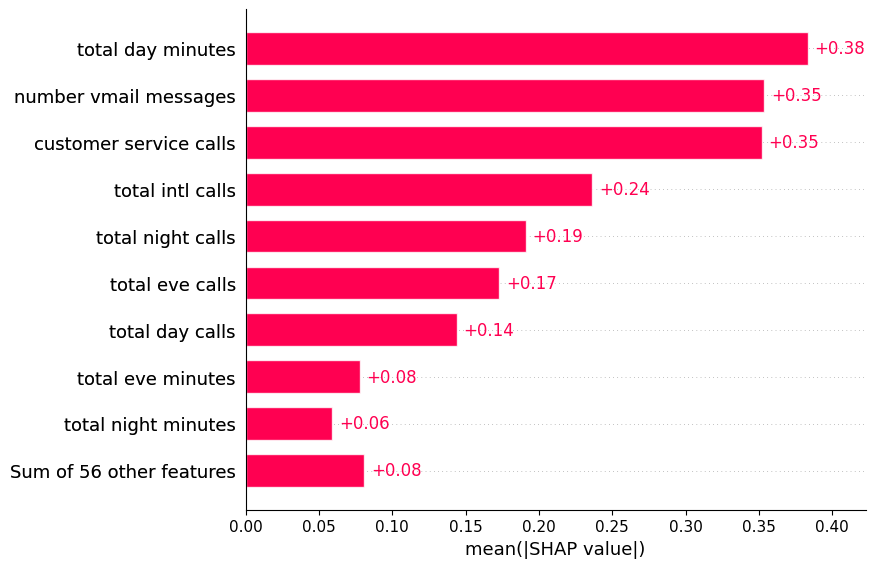

In [ ]:
shap.plots.bar(shap_values_c)

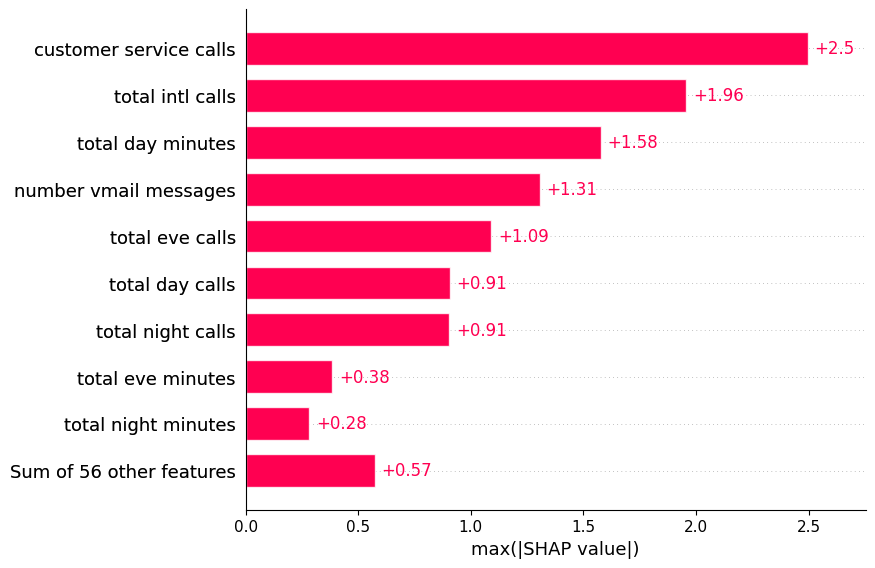

In [ ]:
shap.plots.bar(shap_values_c.abs.max(0))

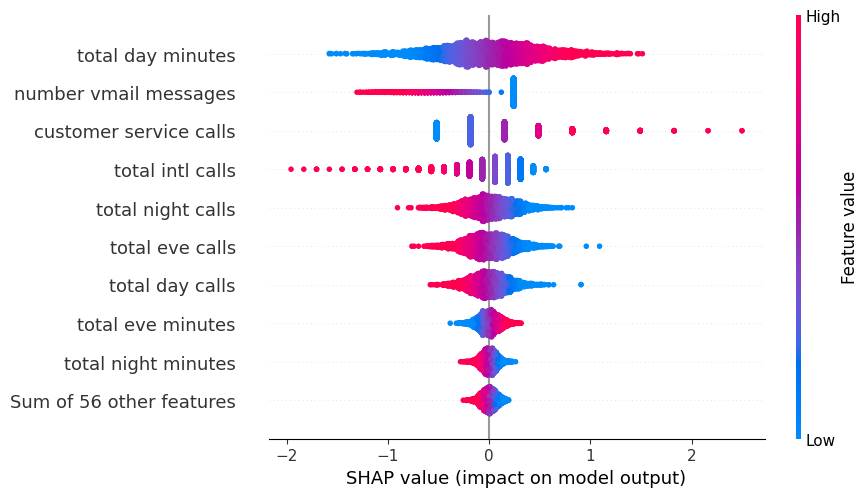

In [ ]:
shap.plots.beeswarm(shap_values_c)

Features with the largest impact: The features at the top of the plot have the largest absolute SHAP values, indicating they have the most significant impact on the model's prediction. From the plot, it appears that total day minutes, customer service calls, and international plan are among the most influential features.
Direction of impact and feature values:
For total day minutes, higher values (red dots towards the right) tend to have positive SHAP values, pushing the prediction towards churn. Lower values (blue dots towards the left) have negative SHAP values, pushing the prediction away from churn.
For customer service calls, a higher number of calls (red dots) are associated with positive SHAP values, increasing the likelihood of churn.
For international plan, having an international plan (indicated by color, likely red) seems to have a significant positive SHAP value, strongly increasing the likelihood of churn.
Spread of SHAP values: The spread of the dots for each feature shows the variability in the feature's impact across different data points.

In [ ]:
explainer = lime.lime_tabular.LimeTabularExplainer(np.array(xtrain),
feature_names=list(xtrain.columns),
class_names=['churn dum'],
verbose=True, mode='classification')
# this record is a no churn scenario
expl = explainer.explain_instance(xtest.iloc[0], l_model.predict_proba,
num_features=16)
expl.as_list()

Intercept 0.18879216606386837
Prediction_local [0.16648944]
Right: 0.2061291422277537


[('total day minutes <= 144.12', -0.09319909385053715),
 ('number vmail messages <= 0.00', 0.08059711452640307),
 ('total eve calls <= 87.00', 0.04934978350181958),
 ('state_MA <= 0.00', -0.03469511288991332),
 ('state_VA <= 0.00', 0.02209333388016318),
 ('1.00 < customer service calls <= 2.00', 0.018275211335295145),
 ('state_CA <= 0.00', -0.017710987883535527),
 ('state_NM <= 0.00', 0.01768626265915332),
 ('state_NH <= 0.00', -0.017545632171607962),
 ('total night minutes <= 167.10', 0.017183021291375798),
 ('state_HI <= 0.00', -0.017005348665905338),
 ('state_DE <= 0.00', -0.0169736977040465),
 ('state_LA <= 0.00', -0.016862504871567464),
 ('state_RI <= 0.00', -0.016009396304391216),
 ('state_TN <= 0.00', 0.015480677855704535),
 ('state_VT <= 0.00', -0.012966359899487712)]

In [ ]:
pd.DataFrame(expl.as_list())

,0,1
0,total day minutes <= 144.12,-0.093199
1,number vmail messages <= 0.00,0.080597
2,total eve calls <= 87.00,0.049350
3,state_MA <= 0.00,-0.034695
4,state_VA <= 0.00,0.022093
5,1.00 < customer service calls <= 2.00,0.018275
6,state_CA <= 0.00,-0.017711
7,state_NM <= 0.00,0.017686
8,state_NH <= 0.00,-0.017546
9,total night minutes <= 167.10,0.017183


In [ ]:
expl.show_in_notebook(show_table=True)